In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform, split_into_windows, split_into_sequences 

In [27]:
ALL_LABELS = tf.constant(['p', 'g', 'slash', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'comma', 'c', 'tab', 'b', 'j', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'u'], dtype=tf.string)

### Load Datasets

In [28]:
# Load MKA Dataset
# mka_path = os.path.dirname(os.getcwd()) + "/data-manipulation/mka_dataset"
# mka_dataset = tf.data.Dataset.load(mka_path)

# Load supplementary dataset
supp_path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"
supp_dataset = tf.data.Dataset.load(supp_path)

supp_dataset = supp_dataset.shuffle(128)

# mka_dataset.cache()
supp_dataset.cache()
# mka_dataset = mka_dataset.prefetch(tf.data.AUTOTUNE)
supp_dataset = supp_dataset.prefetch(AUTOTUNE)

# print(f"MKA Dataset {mka_dataset.element_spec}\nLength: {tf.data.experimental.cardinality(mka_dataset).numpy()}")
print(f"Supp Dataset {supp_dataset.element_spec}\nLength: {tf.data.experimental.cardinality(supp_dataset).numpy()}")

spectrogram_dataset = supp_dataset

# Add channel dimension for conv network
spectrogram_dataset = spectrogram_dataset.map(
    lambda spectrogram, label: (tf.expand_dims(spectrogram, axis=-1), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

Supp Dataset (TensorSpec(shape=(19, 111), dtype=tf.float32, name=None), TensorSpec(shape=(54,), dtype=tf.int32, name=None))
Length: 11886


### Analyze Dataset

Labels in ALL_LABELS but not in my labels: []


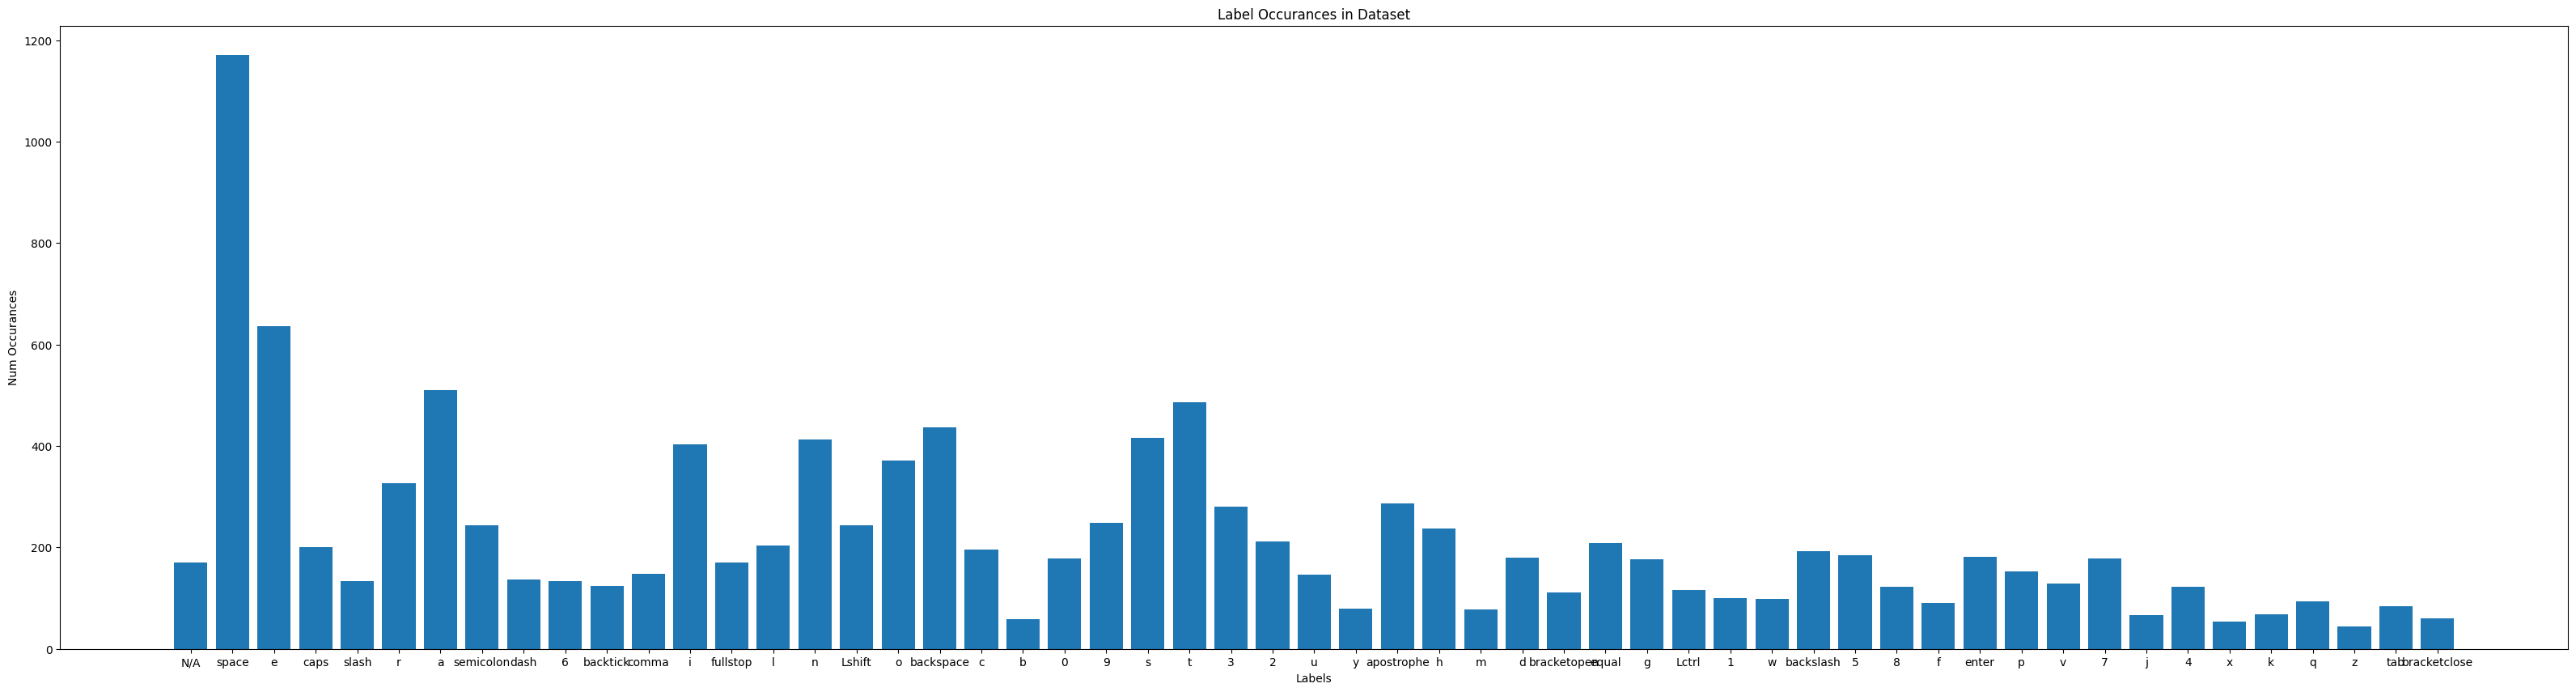

In [29]:
dataset_size = 0
labels = []
label_occurances = []
for spectrogram, label in spectrogram_dataset:
    dataset_size += 1
    label = multi_label_binary_decode_tensor(tf, label)
    if label:
        label = label[0]
        if label in labels:
            index = labels.index(label)
            label_occurances[index] += 1
        else:
            labels.append(label)
            label_occurances.append(1)
# print(len(labels))
# print(len(label_occurances))

labels_tensor = tf.constant(labels, dtype=tf.string)

difference = tf.sets.difference(tf.expand_dims(ALL_LABELS, axis=0), 
                                tf.expand_dims(labels_tensor, axis=0))

# Convert sparse result to dense
missing_labels = tf.sparse.to_dense(difference)[0].numpy()

print("Labels in ALL_LABELS but not in my labels:", missing_labels)



# Insert no label/noise
labels.insert(0, "N/A")
label_occurances.insert(0, dataset_size - sum(label_occurances))

plt.figure(figsize=(40,10))
plt.bar(labels, label_occurances)
plt.title("Label Occurances in Dataset")
plt.xlabel("Labels")
plt.ylabel("Num Occurances")
plt.show()

### Prepare Dataset for Training

In [30]:
dataset_size = sum(1 for _ in spectrogram_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

# Split into train val and test datasets
train_dataset = spectrogram_dataset.take(train_size)
remaining_dataset = spectrogram_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

### Calculate Class Weights
Since the dataset may be imbalanced with different classes, especially with the no key pressed class, we must calculate the class weights so the model is not biased towards the majority class

In [ ]:
def calculate_class_weights(labels):
    num_classes = labels.shape[1]
    class_counts = np.sum(labels, axis=0)
    total_counts = np.sum(class_counts)

    class_weights = {
        i: total_counts / (num_classes * class_counts[i]) if class_counts[i] > 0 else 0
        for i in range(num_classes)
    }
    return class_weights

# Example usage
all_labels = np.stack([label.numpy() for _, label in train_dataset])
class_weights = calculate_class_weights(all_labels)
print("Class Weights:", class_weights)

Class Weights: {0: 1.4464340373431281, 1: 1.2501322751322752, 2: 1.9232804232804233, 3: 1.3061083471531232, 4: 1.1077121425222691, 5: 2.035099052540913, 6: 0.4197086775024425, 7: 1.8231095679012346, 8: 1.1590630365464802, 9: 1.0803612254229538, 10: 1.190602166792643, 11: 0.47047988849064115, 12: 3.8893004115226337, 13: 6.482167352537723, 14: 2.243827160493827, 15: 1.562665343915344, 16: 1.143911885741951, 17: 3.017560664112388, 18: 3.5003703703703706, 19: 3.2410836762688615, 20: 1.9232804232804233, 21: 0.511750054147715, 22: 0.45936619033731896, 23: 2.365115115115115, 24: 2.4650495565988524, 25: 0.5700928941971287, 26: 0.7710066895088922, 27: 2.3335802469135802, 28: 1.7859032501889645, 29: 0.1861899133175729, 30: 1.067186088527552, 31: 0.5452290296527057, 32: 0.9563853470957296, 33: 0.5385185185185185, 34: 0.6506264628941208, 35: 2.011707109408259, 36: 0.8794900428066257, 37: 2.5002645502645504, 38: 1.1825575575575575, 39: 3.2410836762688615, 40: 0.8496044588277598, 41: 4.3754629629629

### Batch and Prefetch datasets

In [32]:
# Batch and prefetch
train_dataset = train_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)

# Model

In [33]:
print(spectrogram_dataset.element_spec)
model = keras.Sequential([
    layers.Input(shape=(19, 111, 1)),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    # layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),

    # layers.Reshape((78, -1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(54, activation="sigmoid")
])

model.summary()

(TensorSpec(shape=(19, 111, 1), dtype=tf.float32, name=None), TensorSpec(shape=(54,), dtype=tf.int32, name=None))


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 19, 111, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 19, 111, 128)   │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 55, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 55, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 63360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,110,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,154,486 (31.11 MB)

 Trainable params: 8,154,486 (31.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=["accuracy", keras.metrics.Precision()] # , 
)

model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    class_weight=class_weights
)

Epoch 1/15


298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0262 - loss: 0.1274 - precision_4: 0.0195 - val_accuracy: 0.1002 - val_loss: 0.0884 - val_precision_4: 0.8182
Epoch 2/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1325 - loss: 0.0836 - precision_4: 0.7705 - val_accuracy: 0.1633 - val_loss: 0.0813 - val_precision_4: 0.7895
Epoch 3/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2661 - loss: 0.0691 - precision_4: 0.7587 - val_accuracy: 0.3165 - val_loss: 0.0675 - val_precision_4: 0.7970
Epoch 4/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4264 - loss: 0.0538 - precision_4: 0.7859 - val_accuracy: 0.3948 - val_loss: 0.0644 - val_precision_4: 0.8023
Epoch 5/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5460 - loss: 0.0427 - precision_4: 0.8163 - val_accuracy: 0.4520 - val_loss: 0.0582 - val_precision_4: 0.6996
Epoch 6/15
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6467 - loss: 0.0334 - precision_4: 0.8403 - val_accuracy: 0.4899 

## Evaluate Model

In [ ]:
def decode_predictions(binary_vector):
    binary_predictions = tf.convert_to_tensor(binary_vector, dtype=tf.int32)

    decoded_predictions = []
    for sample_predictions in binary_predictions:  # Iterate over batch
        indices = tf.where(sample_predictions > 0)  # Indices of positive predictions
        decoded = [ALL_LABELS[i] for i in tf.reshape(indices, [-1]).numpy()]  # Map indices to labels
        decoded_predictions.append(decoded)
    return decoded_predictions

In [36]:


# # conf_matrix = confusion_matrix(y_true, y_pred)

# # print(classification_report(y_true, y_pred, target_names=class_names))


# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5201 - loss: 0.0822 - precision_4: 0.8392
Loss: 0.08542419970035553, Accuracy: 0.5092437267303467, Precision: 0.8250591158866882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━

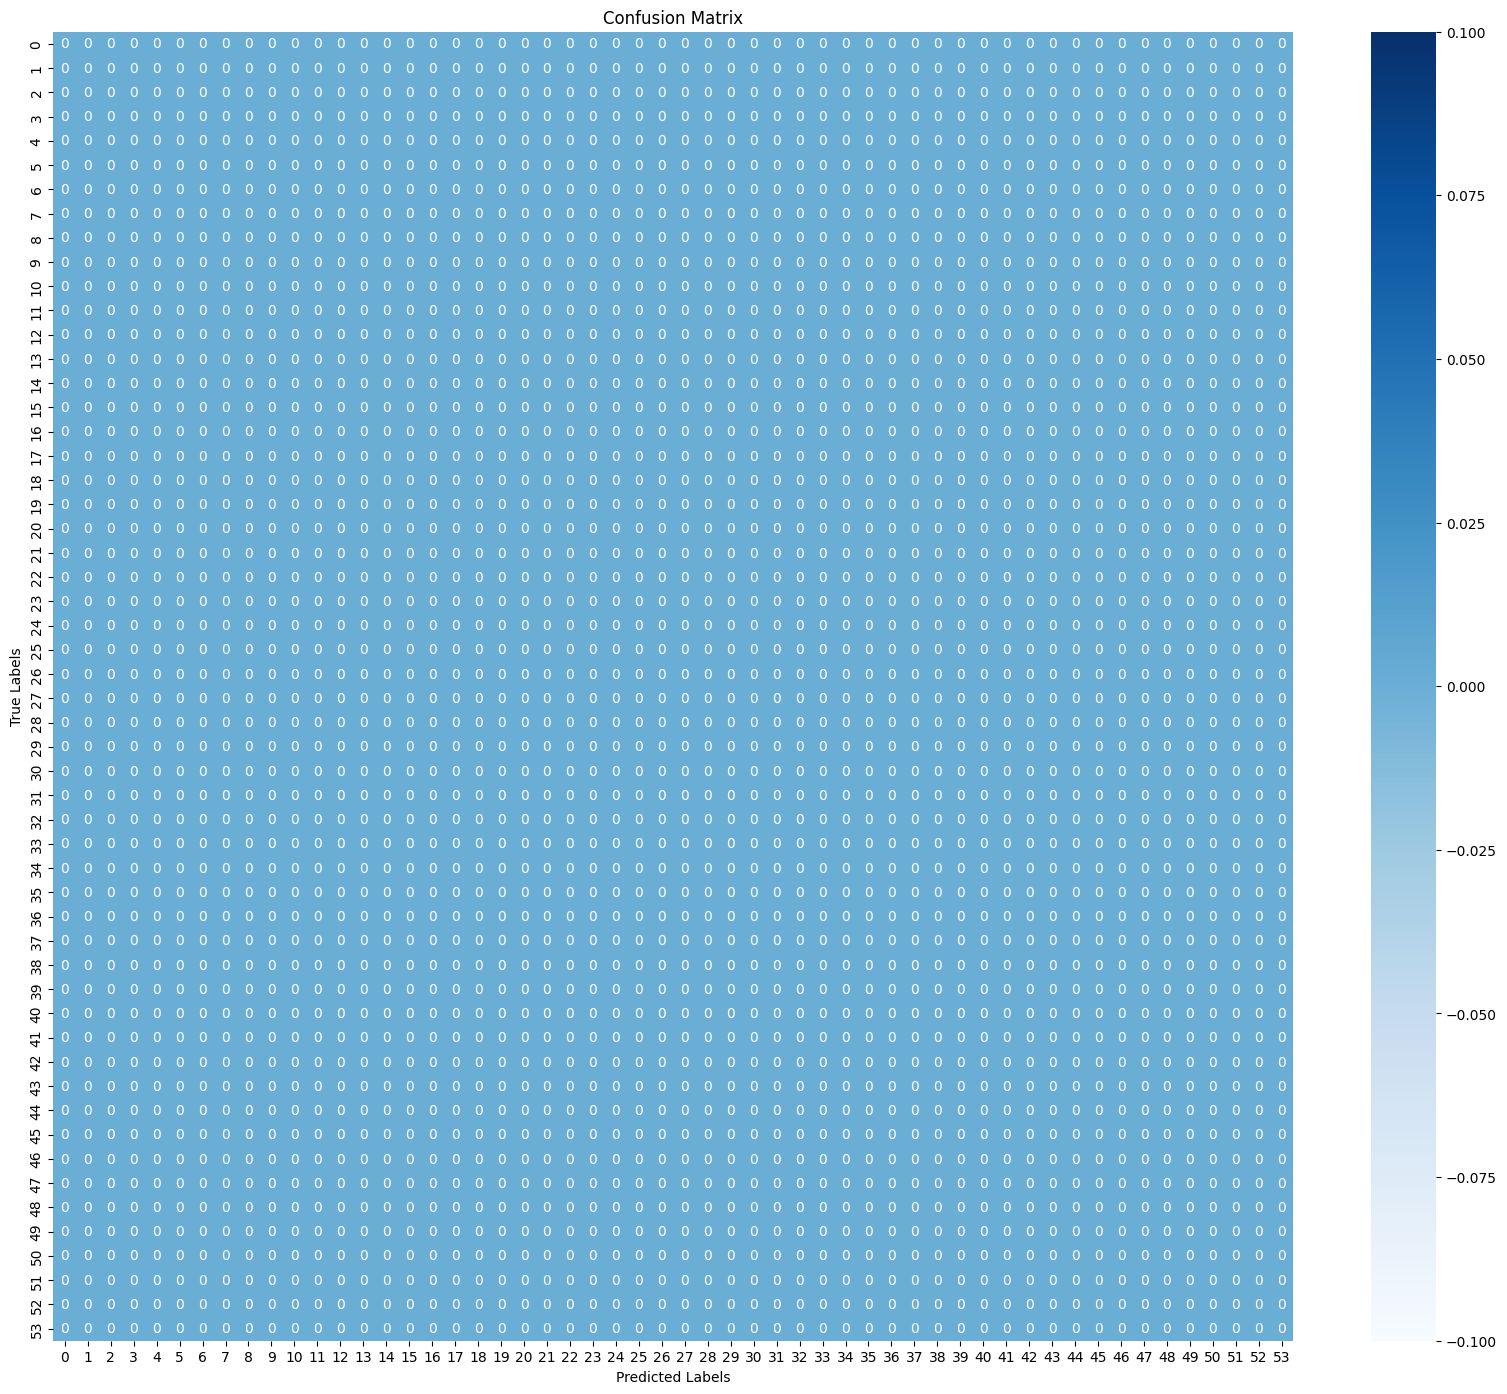

In [37]:
loss, accuracy, precision = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}")


y_true = []
y_pred = []

# Iterate through the test dataset
for spectrogram, label in test_dataset:
    # Get predictions
    predictions = model.predict(spectrogram)
    
    # Convert raw predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert true labels from one-hot encoding to class indices
    label = np.argmax(label.numpy(), axis=1)
    
    # Collect true labels and predictions
    y_true.extend(label)  # `label` is already a NumPy array after np.argmax
    y_pred.extend(predicted_classes)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix

class_names = [label.decode('utf-8') for label in ALL_LABELS.numpy()]
conf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
print("Confusion Matrix:\n", conf_matrix)



plt.figure(figsize=(20, 17))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Optimize Model

In [38]:
def calculate_class_wise_accuracy(test_dataset, model, threshold=0.5):
    # Get the number of classes from the dataset
    num_classes = test_dataset.element_spec[1].shape[1]  # Assuming labels are 1D with num_classes entries
    print(num_classes)
    # Initialize counters for TP, TN
    tp = np.zeros(num_classes, dtype=int)  # True positives per class
    tn = np.zeros(num_classes, dtype=int)  # True negatives per class
    total_samples = 0

    # Iterate over the test dataset
    for spectrogram, label in test_dataset:
        if tf.reduce_all(label == 0).numpy():
            continue
        predictions = model.predict(spectrogram)  # Get predictions
        binary_predictions = (predictions > threshold).astype(int)  # Apply threshold

        # Convert tensors to NumPy arrays
        binary_predictions = np.array(binary_predictions)
        label = label.numpy()

        # Update TP and TN counts (column-wise summation across batch)
        tp += np.sum((binary_predictions == 1) & (label == 1), axis=0)
        tn += np.sum((binary_predictions == 0) & (label == 0), axis=0)
        total_samples += label.shape[0]  # Update total number of samples

    # Calculate class-wise accuracy
    class_accuracies = {
        i: (tp[i] + tn[i]) / total_samples for i in range(num_classes)
    }

    return class_accuracies
class_accuracies = calculate_class_wise_accuracy(test_dataset, model)
print("Class-Wise Accuracies:", class_accuracies)

54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━